**Author:** Raoul Malm  

**Description:** 

Given is a training set of 891 samples listing passengers who survived or did not survive the Titanic disaster. The goal is to construct a model that can predict from a test dataset of 418 passengers not containing the survival information if these passengers in the test dataset survived or not. This is a supervised classification task. The individual steps for the solution are:
- Analyze data
- Manipulate data: complete, convert, create and delete features
- Model data: implement kNN, SVC with linear/rbf kernel, Naive Bayes, Decision Tree, Random Forest, Ada Boost, Extra Tree, Gradient Boosting and Neural Network classifiers
- Validate models and analyze feature importance
- Analyze the correlation of model predictions and perform model stacking
- Choose a model and submit the prediction for the test set

**Results:** 

- Using a 10-fold cross-validation on the labeled training data single base models can achieve roughly an 82% accuracy on the validation set. Stacking several base models and training a meta model on their predictions we can achieve an accuracy of 0.7990 on the test set. 

**Outline:**

1. [Libraries and settings](#1-bullet)  
2. [Analyze data](#2-bullet)  
    2.1 [First look](#2.1-bullet)  
    2.2 [Check correlation with Survived](#2.2-bullet)  
3. [Manipulate data](#3-bullet)  
    3.1 [Complete and convert features : Sex, Embarked, Age, Fare](#3.1-bullet)  
    3.2 [Create new features: Title,FamilySize,IsAlone,AgeBin*Pclass,NameLength,HasCabin](#3.2-bullet)  
    3.3 [Feature selection](#3.3-bullet)  
4. [Model and validate data](#4-bullet)  
    4.1 [Create training, validation, testing sets](#4.1-bullet)  
    4.2 [Neural network implementation](#4.2-bullet)  
    4.3 [Base models with sklearn](#4.3-bullet)  
    4.4 [Comparison of models](#4.4-bullet)  
    4.5 [Look at feature importance](#4.5-bullet)  
    4.6 [Stacking of models](#4.6-bullet)      
5. [Predict and submit test results](#5-bullet)  


**References:**

[Titanic Data Science Solutions by Manav Sehgal](https://www.kaggle.com/startupsci/titanic-data-science-solutions?scriptVersionId=1145136)

[Introduction to Ensembling/Stacking in Python by Anisotropic](https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python)


# 1. Libraries and settings <a class="anchor" id="1-bullet"></a> 

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
import sklearn.linear_model
import sklearn.svm
import sklearn.ensemble
import sklearn.neighbors
import sklearn.naive_bayes
import sklearn.tree
import sklearn.model_selection
import sklearn.pipeline  
import sklearn.preprocessing
from subprocess import check_output
import seaborn as sns
import os
import tensorflow as tf
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

#display parent directory and working directory
print(os.path.dirname(os.getcwd())+':', os.listdir(os.path.dirname(os.getcwd())));
print(os.getcwd()+':', os.listdir(os.getcwd()));

/Users/raoul/Documents/anaconda-workspace/Kaggle/Titanic_Classification: ['.DS_Store', 'input', 'working']
/Users/raoul/Documents/anaconda-workspace/Kaggle/Titanic_Classification/working: ['.ipynb_checkpoints', 'submission.csv', 'Titanic_Survival_0.7990_Test_Acc.ipynb']


# 2. Analyze data <a class="anchor" id="2-bullet"></a> 

The train/test sets have 891/418 rows with 12/11 columns. The features are:
- Survived: 0 = No, 1 = Yes 
- Pclass: Ticket class 1 = 1st, 2 = 2nd, 3 = 3rd 
- Name: Name of the passenger
- Sex: male, female 
- Age: Age in years. Is fractional if less than 1. If the age is estimated, it is in the form of xx.5.
- SibSp: # of siblings / spouses aboard the Titanic (Sibling = brother, sister, stepbrother, stepsister, Spouse = husband, wife). Mistresses and fiancés were ignored
- Parch: # of parents / children aboard the Titanic (Parent = mother, father, Child = daughter, son, stepdaughter, stepson). Some children travelled only with a nanny, therefore Parch=0 for them.
- Ticket: Ticket number 
- Fare: Passenger fare 
- Cabin: Cabin number 
- Embarked: Port of Embarkation C = Cherbourg, Q = Queenstown, S = Southampton

The features can be characterized by different types:
- numerical: Age (continuous, float64), Fare (continuous, float64), SibSp (discrete, int64), Parch (discrete, int64)
- categorial: Sex (string), Pclass (int64), Embarked (character), Survived (int64), Ticket (alphanumeric, string), Cabin (alphanumeric, string), Name (string)

 


## 2.1 First look <a class="anchor" id="2.1-bullet"></a> 

In [2]:
# read data and have a first look at it
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')

train_df.info()
print('_'*40)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null

In [3]:
# missing values
print(train_df.isnull().sum())
print('')
print(test_df.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [4]:
# look at the first five rows
#train_df.head()

In [5]:
# look at the first five rows
#test_df.head() 

In [6]:
# describe numerical data
#train_df.describe()

In [7]:
# describe numerical data
#test_df.describe()

In [8]:
# describe object data
#train_df.describe(include=['O'])

In [9]:
# describe object data
#test_df.describe(include=['O'])

## 2.2 Check correlation with Survived  <a class="anchor" id="2.2-bullet"></a> 

In [10]:
# check Pclass - Survived correlation
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [11]:
# check Sex - Survived correlation
train_df[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [12]:
# check SibSp - Survived correlation
train_df[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [13]:
# check Parch - Survived correlation
train_df[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


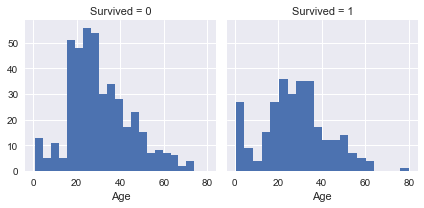

In [14]:
# Age histograms depending on Survived
grid = sns.FacetGrid(train_df, col='Survived');
grid.map(plt.hist, 'Age', bins=20);

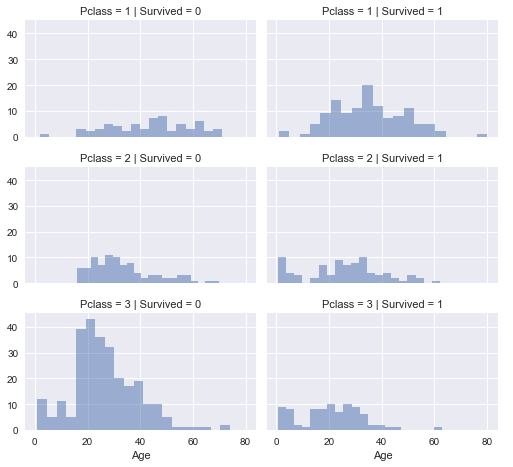

In [15]:
# Age histograms depending on Survived, Pclass
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

/Users/raoul/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


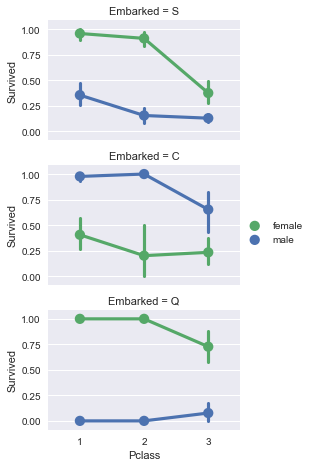

In [16]:
# Survived values depending on Embarked, Sex
grid = sns.FacetGrid(train_df, row='Embarked', size=2.2, aspect=1.6);
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep');
grid.add_legend();

/Users/raoul/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


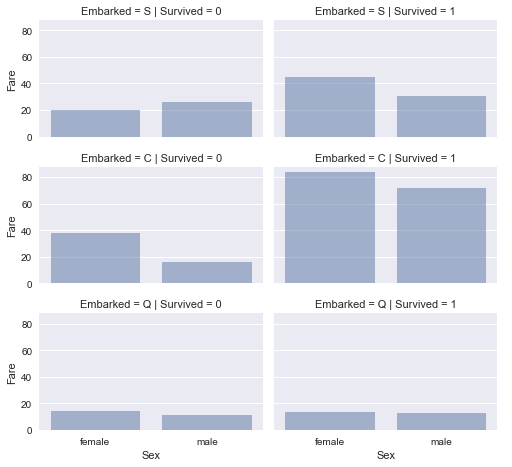

In [17]:
# Fare depending on Embarked, Survived, Sex
grid = sns.FacetGrid(train_df, row='Embarked', col='Survived', size=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend()

# 3. Manipulate data <a class="anchor" id="3-bullet"></a> 

By having analyzed the data we will perform the following steps:

- create new feature: Title
- convert feature: Sex
- complete and convert feature: Age
- create new features: IsAlone, Age*Pclass
- complete and convert feature: Embarked 
- complete and convert feature: Fare
- convert feature: Pclass
- create new features: NameLength, HasCabin
- drop features
- visualize correlations of features

In [18]:
# combine train and test data for manipulation
data_df = pd.concat((train_df, test_df)).reset_index(drop=True)
print('data_df.shape = ', data_df.shape)

data_df.shape =  (1309, 12)


### 3.1 Complete and convert features : Sex, Embarked, Age, Fare <a class="anchor" id="3.1-bullet"></a> 

In [19]:
# make categorial feature numerical
data_df['Sex'] = data_df['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

In [20]:
print(data_df.Embarked.isnull().values.sum(),'missing values')

# most frequent occurence of Embarked value
freq_port = data_df.Embarked.dropna().mode()[0]
print(freq_port,'= most frequent');

# replace na entries with most frequent value of Embarked
data_df['Embarked'] = data_df['Embarked'].fillna(freq_port)
    
data_df[['Embarked', 'Survived']].groupby(['Embarked'],
    as_index=False).mean().sort_values(by='Survived', ascending=False)

2 missing values
S = most frequent


,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


In [21]:
# complete missing age entries by using information on Sex, Pclass

# many missing values
print(data_df.Age.isnull().values.sum(), 'missing values')

guess_ages = np.zeros((2,3));

for i in range(0, 2):
    for j in range(0, 3):
        guess_df = data_df[(data_df['Sex'] == i) & 
                           (data_df['Pclass'] == j+1)]['Age'].dropna()

        
        age_mean = guess_df.mean()
        age_std = guess_df.std()
        age_guess = np.random.normal(age_mean, age_std)

        #age_guess = guess_df.median()
        #print(age_guess)

        guess_ages[i,j] = int((age_guess/0.5 + 0.5) * 0.5)


for i in range(0, 2):
    for j in range(0, 3):
        data_df.loc[(data_df.Age.isnull()) & (data_df.Sex == i) & 
                    (data_df.Pclass == j+1),'Age'] = guess_ages[i,j]

data_df['Age'] = data_df['Age'].astype(int)

print(data_df.Age.isnull().values.sum(), 'missing values')

#train_df.head()

263 missing values
0 missing values


In [22]:
# create new feature AgeBand
data_df['AgeBand'] = pd.qcut(data_df['Age'], 5)
data_df[['AgeBand', 'Survived']].groupby(['AgeBand'], 
            as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(-0.001, 21.0]",0.432039
1,"(21.0, 28.0]",0.381250
2,"(28.0, 35.0]",0.467391
3,"(35.0, 40.0]",0.267442
4,"(40.0, 80.0]",0.355030


In [23]:
# Creat AgeBins with ordinals based on the bands in AgeBand
data_df.loc[data_df['Age'] <= 16, 'AgeBin'] = 0
data_df.loc[(data_df['Age'] > 16) & (data_df['Age'] <= 32), 'AgeBin'] = 1
data_df.loc[(data_df['Age'] > 32) & (data_df['Age'] <= 48), 'AgeBin'] = 2
data_df.loc[(data_df['Age'] > 48) & (data_df['Age'] <= 64), 'AgeBin'] = 3
data_df.loc[data_df['Age'] > 64, 'AgeBin']

# drop AgeBand
data_df = data_df.drop(['AgeBand'], axis=1)

print(data_df.AgeBin.isnull().values.sum(), 'missing values')
#data_df.head()

41 missing values


In [24]:
# complete feature Fare

print(data_df.Fare.isnull().values.sum(), 'missing values')
data_df['Fare'].fillna(data_df['Fare'].dropna().median(), inplace=True)
print(data_df.Fare.isnull().values.sum(), 'missing values')

# create feature FareBand
data_df['FareBand'] = pd.qcut(data_df['Fare'], 5)
data_df[['FareBand', 'Survived']].groupby(['FareBand'], 
        as_index=False).mean().sort_values(by='FareBand', ascending=True)

1 missing values
0 missing values


,FareBand,Survived
0,"(-0.001, 7.854]",0.217877
1,"(7.854, 10.5]",0.201087
2,"(10.5, 21.558]",0.426901
3,"(21.558, 41.579]",0.443243
4,"(41.579, 512.329]",0.645349


In [25]:
# create feature FareBin by ordinals based on FareBand
data_df.loc[ data_df['Fare'] <= 7.91, 'FareBin'] = 0
data_df.loc[(data_df['Fare'] > 7.91) & (data_df['Fare'] <= 14.454), 'FareBin'] = 1
data_df.loc[(data_df['Fare'] > 14.454) & (data_df['Fare'] <= 31), 'FareBin']   = 2
data_df.loc[ data_df['Fare'] > 31, 'FareBin'] = 3
data_df['FareBin'] = data_df['FareBin'].astype(int)

data_df = data_df.drop(['FareBand'], axis=1)
    
#train_df.head()

### 3.2 Create new features: Title, FamilySize, IsAlone, Age*Pclass, NameLength, HasCabin <a class="anchor" id="3.2-bullet"></a> 

In [26]:
# extract title from Name and then create new feature: Title  
data_df['Title'] = data_df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
pd.crosstab(train_df['Survived'], data_df['Title'])

Title,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Survived,,,,,,,,,,,,,,,,,
0,1,1,0,1,4,1,0,1,17,55,0,0,436,26,0,6,0
1,0,1,1,0,3,0,1,1,23,127,2,1,81,99,1,0,1


In [27]:
# correlation of Sex and Title
pd.crosstab(data_df['Sex'], data_df['Title'])

Title,Capt,Col,Countess,Don,Dona,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,,
0,1,4,0,1,0,7,1,0,2,61,0,0,0,757,0,0,8,1
1,0,0,1,0,1,1,0,1,0,0,260,2,1,0,197,2,0,0


In [28]:
# reduce the number of titles
data_df['Title'] = data_df['Title'].replace(['Lady', 'Countess','Capt', 'Col',
                                             'Don', 'Dr', 'Major', 'Rev', 'Sir',
                                             'Jonkheer', 'Dona'], 'Rare')
data_df['Title'] = data_df['Title'].replace('Mlle', 'Miss')
data_df['Title'] = data_df['Title'].replace('Ms', 'Miss')
data_df['Title'] = data_df['Title'].replace('Mme', 'Mrs')

# no missing titles
print('missing titles = ', data_df.Title.isnull().sum())

#data_df.head()

missing titles =  0


In [29]:
# create new feature FamilySize
data_df['FamilySize'] = data_df['SibSp'] + data_df['Parch'] + 1
data_df[['FamilySize', 'Survived']].groupby(['FamilySize'],
    as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


In [30]:
# create new feature IsAlone
data_df['IsAlone'] = 0
data_df.loc[data_df['FamilySize'] == 1, 'IsAlone'] = 1
data_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


In [31]:
# create new feature Age*Pclass
data_df['AgeBin*Pclass'] = data_df.AgeBin * data_df.Pclass
data_df[['AgeBin*Pclass', 'Survived']].groupby(['AgeBin*Pclass'], as_index=False).mean()

,AgeBin*Pclass,Survived
0,0.0,0.558824
1,1.0,0.728814
2,2.0,0.549133
3,3.0,0.336806
4,4.0,0.446809
5,6.0,0.121547
6,9.0,0.111111


In [32]:
# create feature: length of the name
data_df['NameLength'] = data_df['Name'].apply(len)
#data_df[['NameLength', 'Survived']].groupby(['NameLength'], as_index=False).mean()

In [33]:
# create feature that tells whether a passenger had a cabin on the Titanic
data_df['HasCabin'] = data_df["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
data_df[['HasCabin', 'Survived']].groupby(['HasCabin'], as_index=False).mean()

,HasCabin,Survived
0,0,0.299854
1,1,0.666667


### 3.3 Feature selection <a class="anchor" id="3.3-bullet"></a> 

In [34]:
## drop features
if True:
    drop_ft = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'AgeBin', 'AgeBin*Pclass',
               'FareBin']
    data_df = data_df.drop(drop_ft, axis=1)
    print("data_df = ", data_df.shape)

data_df =  (1309, 13)


In [35]:
## use LabelEncoding or dummy variables on all categorial features

cols = data_df.select_dtypes(exclude = [np.number]).columns.values
print('numerical columns:', data_df.select_dtypes(include = 
                                                  [np.number]).columns.values.shape[0])
print('categorial columns:', cols.shape[0])

if True:
    # create dummy variables
    data_df = pd.get_dummies(data_df).copy()
else:
    # create one-hot encodings
    for c in cols:
        lbl = sklearn.preprocessing.LabelEncoder() 
        lbl.fit(list(data_df[c].values)) 
        data_df[c] = lbl.transform(list(data_df[c].values))

# final shape        
print('data_df.shape = ', data_df.shape)

numerical columns: 11
categorial columns: 2
data_df.shape =  (1309, 19)


In [36]:
# check data_df
print(data_df.isnull().sum())
data_df.head()

Age               0
Fare              0
Parch             0
Pclass            0
Sex               0
SibSp             0
Survived        418
FamilySize        0
IsAlone           0
NameLength        0
HasCabin          0
Embarked_C        0
Embarked_Q        0
Embarked_S        0
Title_Master      0
Title_Miss        0
Title_Mr          0
Title_Mrs         0
Title_Rare        0
dtype: int64


,Age,Fare,Parch,Pclass,Sex,SibSp,Survived,FamilySize,IsAlone,NameLength,HasCabin,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,22,7.2500,0,3,0,1,0.0,2,0,23,0,0,0,1,0,0,1,0,0
1,38,71.2833,0,1,1,1,1.0,2,0,51,1,1,0,0,0,0,0,1,0
2,26,7.9250,0,3,1,0,1.0,1,1,22,0,0,0,1,0,1,0,0,0
3,35,53.1000,0,1,1,1,1.0,2,0,44,1,0,0,1,0,0,0,1,0
4,35,8.0500,0,3,0,0,0.0,1,1,24,0,0,0,1,0,0,1,0,0


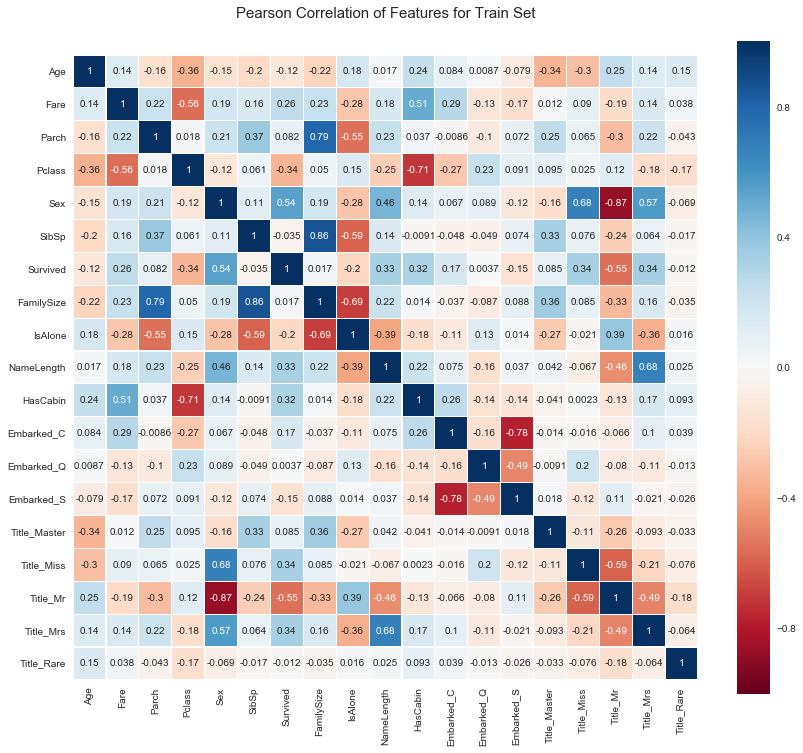

In [37]:
# pearson correlation of features
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features for Train Set', y=1.05, size=15)
sns.heatmap(data_df.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)


# 4. Model data <a class="anchor" id="4-bullet"></a> 

### 4.1 Create training, validation, testing sets <a class="anchor" id="4.1-bullet"></a> 

In [38]:
## create training, validation, testing sets

# function to normalize data
def normalize_data(data): 
    # scale features using statistics that are robust to outliers
    rs = sklearn.preprocessing.RobustScaler()
    rs.fit(data)
    data = rs.transform(data)
    #x_train_valid = (x_train_valid)/(x_train_valid.max(axis=0));
    #x_test = (x_test)/(x_test.max(axis=0));
    return data

# get accuracy from classes
def get_accuracy(y_target, y_pred):
    y_target_class = get_classes(y_target).reshape(-1,)
    y_pred = get_classes(y_pred).reshape(-1,)
    return np.mean(y_target_class == y_pred)

# get classes from probabilities
def get_classes(y_proba):
    return np.greater(y_proba, 0.5).astype(np.int) 

# create train/validation and test sets as copies from dataframes
x_train_valid = data_df.drop(['Survived'],axis=1)[:train_df.shape[0]].copy().values
y_train_valid = data_df['Survived'][:train_df.shape[0]].copy().values.reshape(-1,)
x_test  = data_df.drop(['Survived'],axis=1)[train_df.shape[0]:].copy().values

# store used features
features_df = pd.DataFrame(data_df.drop(["Survived"], axis=1).columns)
features_df.columns = ['Features']
print(features_df)
print('')

# normalize train, validation, test data
x_train_valid = normalize_data(x_train_valid)
x_test = normalize_data(x_test)
          
print('x_train_valid.shape = ', x_train_valid.shape)
print('y_train_valid.shape = ', y_train_valid.shape)
print('x_test.shape = ', x_test.shape)

        Features
0            Age
1           Fare
2          Parch
3         Pclass
4            Sex
5          SibSp
6     FamilySize
7        IsAlone
8     NameLength
9       HasCabin
10    Embarked_C
11    Embarked_Q
12    Embarked_S
13  Title_Master
14    Title_Miss
15      Title_Mr
16     Title_Mrs
17    Title_Rare

x_train_valid.shape =  (891, 18)
y_train_valid.shape =  (891,)
x_test.shape =  (418, 18)


### 4.2 Neural network implementation <a class="anchor" id="4.2-bullet"></a> 

In [39]:
## neural network implementation

# parameters for batch function
perm_array_train = np.array([])
index_in_epoch = 0 

# function to get the next mini batch
def next_batch(batch_size, x_train, y_train):
    global index_in_epoch, perm_array_train
    
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if not len(perm_array_train) == len(x_train):
        perm_array_train = np.arange(len(x_train))
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array_train) # shuffle data
        start = 0 # start next epoch
        index_in_epoch = batch_size # set index to batch size
                
    end = index_in_epoch
    
    x_tr  = x_train[perm_array_train[start:end]]
    y_tr  = y_train[perm_array_train[start:end]].reshape(-1,1)
     
    return x_tr, y_tr


# function to create the graph
def create_nn_graph(num_input_features = 10, num_output_features = 1):

    # reset default graph
    tf.reset_default_graph()

    # parameters of NN architecture
    x_size = num_input_features # number of features
    y_size = num_output_features # output size
    n_n_fc1 = 1024; # number of neurons of first layer
    n_n_fc2 = 1024; # number of neurons of second layer

    # variables for input and output 
    x_data = tf.placeholder('float', shape=[None, x_size])
    y_data = tf.placeholder('float', shape=[None, y_size])

    # 1.layer: fully connected
    W_fc1 = tf.Variable(tf.truncated_normal(shape = [x_size, n_n_fc1], stddev = 0.1))
    b_fc1 = tf.Variable(tf.constant(0.1, shape = [n_n_fc1]))  
    h_fc1 = tf.nn.relu(tf.matmul(x_data, W_fc1) + b_fc1)

    # dropout
    tf_keep_prob = tf.placeholder('float')
    h_fc1_drop = tf.nn.dropout(h_fc1, tf_keep_prob)

    # 2.layer: fully connected
    W_fc2 = tf.Variable(tf.truncated_normal(shape = [n_n_fc1, n_n_fc2], stddev = 0.1)) 
    b_fc2 = tf.Variable(tf.constant(0.1, shape = [n_n_fc2]))  
    h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2) 

    # dropout
    h_fc2_drop = tf.nn.dropout(h_fc2, tf_keep_prob)

    # 3.layer: fully connected
    W_fc3 = tf.Variable(tf.truncated_normal(shape = [n_n_fc2, y_size], stddev = 0.1)) 
    b_fc3 = tf.Variable(tf.constant(0.1, shape = [y_size]))  
    z_pred = tf.matmul(h_fc2_drop, W_fc3) + b_fc3  

    # cost function
    cross_entropy = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        labels=y_data, logits=z_pred));

    # optimisation function
    tf_learn_rate = tf.placeholder(dtype='float', name="tf_learn_rate")
    train_step = tf.train.AdamOptimizer(tf_learn_rate).minimize(cross_entropy)

    # evaluation
    y_pred_proba = tf.cast(tf.nn.sigmoid(z_pred),dtype = tf.float32);
    y_pred_class = tf.cast(tf.greater(y_pred_proba, 0.5),'float')
    accuracy = tf.reduce_mean(tf.cast(tf.equal(y_pred_class, y_data ), 'float'))
 
    # tf tensors
    tf_tensors = {'train_step': train_step, 'cross_entropy': cross_entropy, 
                  'y_pred_proba': y_pred_proba,'accuracy': accuracy,
                  'tf_keep_prob': tf_keep_prob, 'tf_learn_rate': tf_learn_rate,
                  'x_data': x_data, 'y_data': y_data}
    
    return tf_tensors


# function to train the graph
def train_nn_graph(tf_tensors, x_train, y_train, x_valid, y_valid, verbose = False):

    # tf tensors
    train_step = tf_tensors['train_step']
    cross_entropy = tf_tensors['cross_entropy']
    y_pred_proba = tf_tensors['y_pred_proba']
    accuracy = tf_tensors['accuracy']
    tf_keep_prob = tf_tensors['tf_keep_prob']
    tf_learn_rate = tf_tensors['tf_learn_rate']
    x_data = tf_tensors['x_data']
    y_data = tf_tensors['y_data']

    # parameters
    keep_prob = 0.5; # dropout regularization with keeping probability
    learn_rate_range = [0.01,0.005,0.0025,0.001,0.001,0.001,0.00075,0.0005,0.00025,0.0001,
                       0.0001,0.0001,0.0001];
    learn_rate_step = 10 # in terms of epochs 
    batch_size = 10 # batch size
    n_epoch = 10 # number of epochs
    cv_num = 10 # number of cross validations
    n_step = -1;
        
    # start TensorFlow session and initialize global variables
    sess = tf.InteractiveSession() 
    sess.run(tf.global_variables_initializer())  
    
    # training model
    for i in range(int(n_epoch*x_train.shape[0]/batch_size)):

        if i%int(learn_rate_step*x_train.shape[0]/batch_size) == 0:
            n_step += 1;
            learn_rate = learn_rate_range[n_step];
            if verbose:
                print('set learnrate = ', learn_rate)

        # get next batch
        x_batch, y_batch = next_batch(batch_size, x_train, y_train)

        sess.run(train_step, feed_dict={x_data: x_batch, y_data: y_batch, 
                                        tf_keep_prob: keep_prob, tf_learn_rate: learn_rate})

        if verbose and i%int(1.*x_train.shape[0]/batch_size) == 0:
            train_loss = sess.run(cross_entropy,feed_dict={x_data: x_train, 
                                                           y_data: y_train, 
                                                           tf_keep_prob: 1.0})

            train_acc = accuracy.eval(feed_dict={x_data: x_train, 
                                                 y_data: y_train, 
                                                 tf_keep_prob: 1.0})    

            valid_loss = sess.run(cross_entropy,feed_dict={x_data: x_valid, 
                                                           y_data: y_valid, 
                                                           tf_keep_prob: 1.0})

            valid_acc = accuracy.eval(feed_dict={x_data: x_valid, 
                                                 y_data: y_valid, 
                                                 tf_keep_prob: 1.0})      

            print('%.2f epoch: train/val loss = %.4f/%.4f, train/val acc = %.4f/%.4f'%(
                (i+1)*batch_size/x_train.shape[0], train_loss, valid_loss, train_acc, 
                valid_acc))

    
    # predictions
    y_train_pred_proba = y_pred_proba.eval(feed_dict={x_data: x_train,
                                                      tf_keep_prob: 1.0}).flatten()
    y_valid_pred_proba = y_pred_proba.eval(feed_dict={x_data: x_valid, 
                                                      tf_keep_prob: 1.0}).flatten()
    y_test_pred_proba = y_pred_proba.eval(feed_dict={x_data: x_test, 
                                                     tf_keep_prob: 1.0}).flatten()
    
    sess.close();
    

    return (y_train_pred_proba, y_valid_pred_proba, y_test_pred_proba)

In [40]:
# check neural network

if False:
    
    # store results
    y_train_pred_proba = {}
    y_valid_pred_proba = {}
    train_acc = {}
    valid_acc = {}
    
    # create graph and receive tf tensors
    tf_tensors = create_nn_graph(x_train_valid.shape[1], 1)

    # cross validations
    cv_num = 10
    kfold = sklearn.model_selection.KFold(cv_num, shuffle=True)

    for train_index, valid_index in kfold.split(x_train_valid):

        x_train = x_train_valid[train_index]
        y_train = y_train_valid[train_index]
        x_valid = x_train_valid[valid_index]
        y_valid = y_train_valid[valid_index]

        # train NN
        (y_train_pred_proba['nn'], 
         y_valid_pred_proba['nn'],
         y_test_pred['nn']) = train_nn_graph(tf_tensors, x_train,  
                                             y_train.reshape(-1,1), x_valid, 
                                             y_valid.reshape(-1,1), False)
        
        # compute accuracy
        train_acc['nn'] = get_accuracy(y_train_pred_proba['nn'], y_train)
        valid_acc['nn'] = get_accuracy(y_valid_pred_proba['nn'], y_valid)
        
        # loss
        print('nn: train/valid accuracy = %.4f/%.4f'%(train_acc['nn'], valid_acc['nn']))

### 4.3 Base models with sklearn <a class="anchor" id="4.3-bullet"></a> 

In [41]:
## base models

# base models
logreg = sklearn.linear_model.LogisticRegression(verbose = 0)
extra_trees = sklearn.ensemble.ExtraTreesClassifier(max_depth=6,n_estimators=10)
gradient_boost = sklearn.ensemble.GradientBoostingClassifier(max_depth=6,n_estimators=10)
random_forest = sklearn.ensemble.RandomForestClassifier(max_depth=6, n_estimators=10)
decision_tree = sklearn.tree.DecisionTreeClassifier(max_depth=6)
gaussianNB = sklearn.naive_bayes.GaussianNB()

# store models in dictionary
base_models = {'logreg': logreg, 'extra_trees': extra_trees,
               'gradient_boost': gradient_boost, 'random_forest': random_forest, 
               'decision_tree': decision_tree, 'gaussianNB': gaussianNB}

# choose models for out-of-folds predictions
take_models = ['logreg', 'extra_trees', 'gradient_boost', 'gaussianNB', 
               'random_forest', 'decision_tree', 'nn']

# train data for meta model
train_acc = {}
valid_acc = {}
y_test_pred_proba = {}
y_train_pred_proba = {}
y_valid_pred_proba = {}


for mn in take_models:
    train_acc[mn] = 0
    valid_acc[mn] = 0
    y_test_pred_proba[mn] = 0

# cross validations
cv_num = 10
kfold = sklearn.model_selection.KFold(cv_num, shuffle=True)

# make out-of-folds predictions from base models
for i,(train_index, valid_index) in enumerate(kfold.split(x_train_valid)):
    
    print(i+1,'. training of models in progress')
    x_train = x_train_valid[train_index]
    y_train = y_train_valid[train_index]
    x_valid = x_train_valid[valid_index]
    y_valid = y_train_valid[valid_index]

    for mn in take_models:
        
        if mn == 'nn':
            # create graph and receive tf tensors
            tf_tensors = create_nn_graph(x_train_valid.shape[1], 1)
            
            # train neural network
            params = train_nn_graph(tf_tensors, x_train, y_train.reshape(-1,1),
                                    x_valid, y_valid.reshape(-1,1), False) 
     
            # save results
            train_acc['nn'] += get_accuracy(params[0], y_train)
            valid_acc['nn'] += get_accuracy(params[1], y_valid)
            y_test_pred_proba['nn'] += params[2]
        
        else:
            # create cloned model from base models
            model = sklearn.base.clone(base_models[mn])
            model.fit(x_train, y_train)
            
            # save results
            train_acc[mn] += get_accuracy(model.predict_proba(x_train)[:,1], y_train)
            valid_acc[mn] += get_accuracy(model.predict_proba(x_valid)[:,1], y_valid)
            y_test_pred_proba[mn] += model.predict_proba(x_test)[:,1]

print('')

# store and print results
for mn in take_models:
    
    train_acc[mn] /= cv_num
    valid_acc[mn] /= cv_num
    y_test_pred_proba[mn] /= cv_num
        
    print(mn,'train/valid accuracy = %.3f/%.3f'%(train_acc[mn], valid_acc[mn]))

# average rmse over the following models
take_model_avg = ['logreg', 'random_forest', 'decision_tree']

train_acc['averaged'] = 0
valid_acc['averaged'] = 0
y_test_pred_proba['averaged'] = 0

for mn in take_model_avg:
    train_acc['averaged'] += train_acc[mn]
    valid_acc['averaged'] += valid_acc[mn]
    y_test_pred_proba['averaged'] += y_test_pred_proba[mn]
    
train_acc['averaged'] /= len(take_model_avg)
valid_acc['averaged'] /= len(take_model_avg)
y_test_pred_proba['averaged'] /= len(take_model_avg)

print('')
print('Average models:', take_model_avg)
print('Averaged models: train/valid accuracy = %.3f/%.3f'%(train_acc['averaged'],
                                                   valid_acc['averaged']))


1 . training of models in progress
2 . training of models in progress
3 . training of models in progress
4 . training of models in progress
5 . training of models in progress
6 . training of models in progress
7 . training of models in progress
8 . training of models in progress
9 . training of models in progress
10 . training of models in progress

logreg train/valid accuracy = 0.835/0.825
extra_trees train/valid accuracy = 0.849/0.826
gradient_boost train/valid accuracy = 0.909/0.817
gaussianNB train/valid accuracy = 0.820/0.813
random_forest train/valid accuracy = 0.875/0.824
decision_tree train/valid accuracy = 0.877/0.807
nn train/valid accuracy = 0.827/0.811

Average models: ['logreg', 'random_forest', 'decision_tree']
Averaged models: train/valid accuracy = 0.862/0.819


### 4.4 Look at feature importance <a class="anchor" id="4.4-bullet"></a> 

In [42]:
# indices of features
features_df.Features

0              Age
1             Fare
2            Parch
3           Pclass
4              Sex
5            SibSp
6       FamilySize
7          IsAlone
8       NameLength
9         HasCabin
10      Embarked_C
11      Embarked_Q
12      Embarked_S
13    Title_Master
14      Title_Miss
15        Title_Mr
16       Title_Mrs
17      Title_Rare
Name: Features, dtype: object

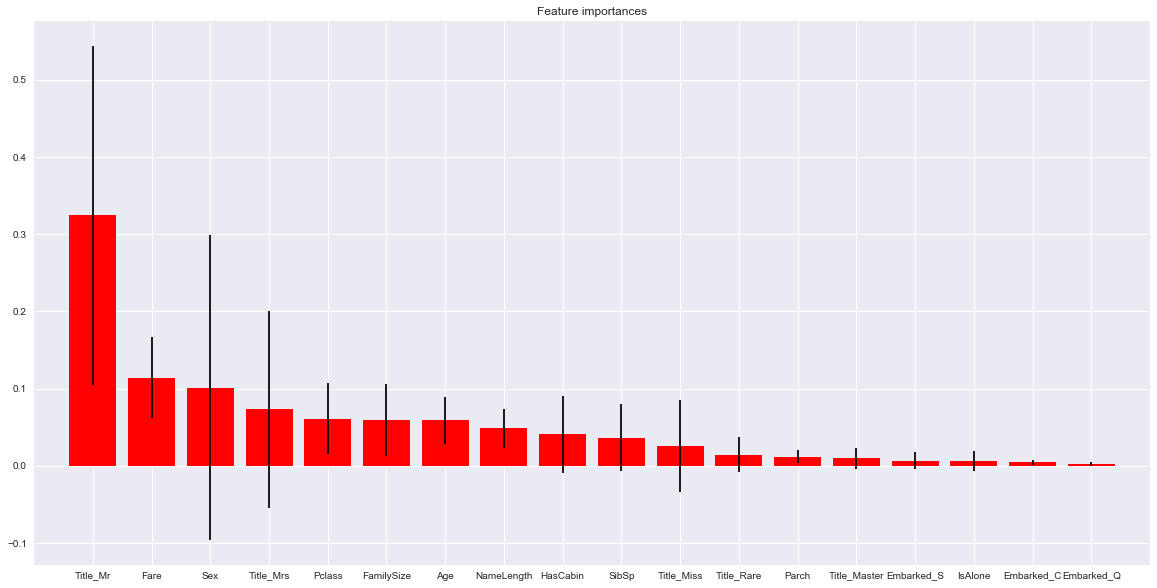

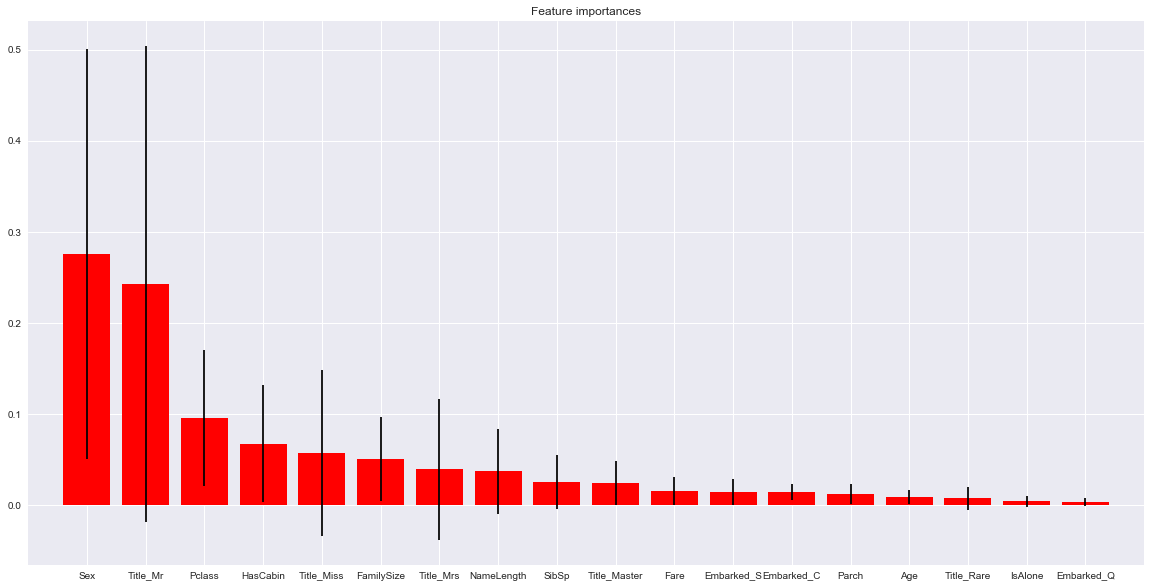

In [43]:
## Look at feature importances using trees

for mn in ['random_forest', 'extra_trees']:
    
    model = sklearn.base.clone(base_models[mn])
    model.fit(x_train_valid, y_train_valid)
        
    ft_importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    indices = np.argsort(ft_importances)[::-1]

    # plot feature importances 
    plt.figure(figsize=(20,10))
    plt.title("Feature importances")
    plt.bar(range(x_train.shape[1]), ft_importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(x_train.shape[1]), features_df.Features.loc[indices].values)
    plt.xlim([-1, x_train.shape[1]])
    plt.show()

### 4.5 Comparison of models <a class="anchor" id="4.5-bullet"></a> 

In [44]:
## summarize the results

models_summary = pd.DataFrame({'Model':[],'Train Acc':[],'Valid Acc':[]})

for i,mn in enumerate(['logreg', 'extra_trees', 'gradient_boost', 'gaussianNB', 
                       'random_forest', 'decision_tree', 'nn', 'averaged']):
    models_summary.loc[i,'Model'] = mn
    models_summary.loc[i,'Train Acc'] = train_acc[mn]
    models_summary.loc[i,'Valid Acc'] = valid_acc[mn]
    
models_summary.sort_values(by='Valid Acc', ascending=False)

,Model,Train Acc,Valid Acc
1,extra_trees,0.848610,0.826042
0,logreg,0.834643,0.824944
4,random_forest,0.875172,0.823808
7,averaged,0.862285,0.818577
2,gradient_boost,0.908841,0.817091
3,gaussianNB,0.820052,0.812534
6,nn,0.826785,0.811473
5,decision_tree,0.877041,0.806979


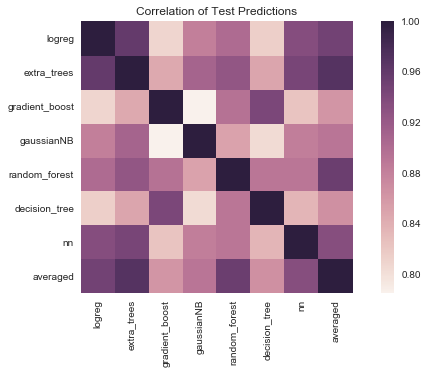

In [45]:
## correlation map of test predictions of the base models

y_test_pred_df = pd.DataFrame({})
for key in y_test_pred_proba.keys():
    y_test_pred_df[key] = get_classes(y_test_pred_proba[key])

corrmat = y_test_pred_df.corr()
corrmat
plt.subplots(figsize=(10,5))
plt.title('Correlation of Test Predictions')
sns.heatmap(corrmat, vmax=1, square=True)

In [46]:
y_test_pred_df.describe()

,logreg,extra_trees,gradient_boost,gaussianNB,random_forest,decision_tree,nn,averaged
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,0.370813,0.389952,0.334928,0.430622,0.354067,0.361244,0.397129,0.375598
std,0.483601,0.488324,0.472531,0.495757,0.478803,0.480937,0.489890,0.484857
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 4.6 Stacking of models <a class="anchor" id="4.6-bullet"></a> 

In [47]:
## Stacking of base models

# choose models for out-of-folds predictions
#take_models = ['logreg','logreg','extra_trees','extra_trees','nn','nn',
#               'random_forest','random_forest','gradient_boost','gradient_boost']

take_models = ['logreg','extra_trees','gaussianNB','nn','decision_tree',
               'random_forest','gradient_boost']

# choose meta model
take_meta_model = 'logreg'

# cross validations
kfold = sklearn.model_selection.KFold(len(take_models), shuffle=True)

# train data for meta model
x_train_meta = np.array([])
y_train_meta = np.array([])
x_test_meta = np.zeros(x_test.shape[0])

print('Out-of-folds predictions:')

# make out-of-folds predictions from base models
for i,(train_index, valid_index) in enumerate(kfold.split(x_train_valid)):
    
    x_train = x_train_valid[train_index]
    y_train = y_train_valid[train_index]
    x_valid = x_train_valid[valid_index]
    y_valid = y_train_valid[valid_index]
    
    if take_models[i] == 'nn':
        # create graph and receive tf tensors
        tf_tensors = create_nn_graph(x_train_valid.shape[1],1)

        # train neural network
        params = train_nn_graph(tf_tensors, x_train, y_train.reshape(-1,1),
                                x_valid, y_valid.reshape(-1,1), False) 

        # save results
        y_train_pred_proba['tmp'] = params[0].reshape(-1,)
        y_valid_pred_proba['tmp'] = params[1].reshape(-1,) 
        y_test_pred_proba['tmp'] = params[2].reshape(-1,)
        
    else:
        # create cloned model from base models
        model = sklearn.base.clone(base_models[take_models[i]])
        model.fit(x_train, y_train)
        y_train_pred_proba['tmp'] = model.predict_proba(x_train)[:,1]
        y_valid_pred_proba['tmp'] = model.predict_proba(x_valid)[:,1]
        y_test_pred_proba['tmp'] = model.predict_proba(x_test)[:,1]

    # collect train and test data for meta model 
    x_train_meta = np.concatenate([x_train_meta, y_valid_pred_proba['tmp']])
    y_train_meta = np.concatenate([y_train_meta, y_valid]) 
    x_test_meta += y_test_pred_proba['tmp']
    
    print(take_models[i],': train/valid accuracy = %.3f/%.3f'%(
        get_accuracy(y_train_pred_proba['tmp'], y_train),
        get_accuracy(y_valid_pred_proba['tmp'], y_valid)))
 
x_train_meta = x_train_meta.reshape(-1,1)
x_test_meta = (x_test_meta/len(take_models)).reshape(-1,1)
y_test_pred_proba['stacked'] = x_test_meta

print('')
print('Stacked models: valid accuracy = %.3f'%get_accuracy(x_train_meta, y_train_meta))

# train meta model
model = sklearn.base.clone(base_models[take_meta_model]) 
model.fit(x_train_meta, y_train_meta)
y_train_pred_proba['meta model'] = model.predict_proba(x_train_meta)[:,1]
y_test_pred_proba['meta model'] = model.predict_proba(x_test_meta)[:,1]

print('Meta model: train accuracy = %.3f'%get_accuracy(x_train_meta, 
                                                       y_train_pred_proba['meta model']))

Out-of-folds predictions:
logreg : train/valid accuracy = 0.832/0.836
extra_trees : train/valid accuracy = 0.860/0.805
gaussianNB : train/valid accuracy = 0.815/0.827
nn : train/valid accuracy = 0.848/0.780
decision_tree : train/valid accuracy = 0.885/0.803
random_forest : train/valid accuracy = 0.869/0.835
gradient_boost : train/valid accuracy = 0.910/0.827

Stacked models: valid accuracy = 0.816
Meta model: train accuracy = 0.987


# 5. Predict and submit test results <a class="anchor" id="5-bullet"></a> 

In [48]:
# choose prediction
y_test_submit = get_classes(y_test_pred_proba['meta model'])
y_test_submit.mean()

0.38755980861244022

In [49]:
# submit prediction
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": y_test_submit
    })

submission.to_csv('submission.csv', index=False)
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
